# Figure 4 notebooks, Part2: single-cell Multiome (RNA+ATAC) - comparison of modalities for cell type annotation - purity of the neighborhoods

Last updated: 7/10/2023

- Computing the distance metrics (cosine, euclidean, correlation, etc.)
- Computing the purity of the nearest neighbors for each cell type across modaliteis (RNA, ATAC, and joint)


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# import modules for computing the similarity metrics (between two cells)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import pearsonr


mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

# Editable text and proper LaTeX fonts in illustrator
# matplotlib.rcParams['ps.useafm'] = True
# Editable fonts. 42 is the magic number
mpl.rcParams['pdf.fonttype'] = 42

# Use "Computer Modern" (LaTeX font) for math numbers
# mpl.rcParams['mathtext.fontset'] = 'cm'
# %matplotlib inline
# change font (for texts)
# mpl.rcParams['font.sans-serif'] = "Arial"
# mpl.rcParams['font.family'] = "sans-serif"

sns.set(style='whitegrid', context='paper')

# ignore warnings regarding fonts
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [5]:
# define the figure path
figpath = "/home/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/excellxgene_tutorial_manuscript/celltype_annotation_tutorial/figures/Figure_RNA_ATAC_multiome/"
sc.settings.figdir = figpath
# set_plotting_style()

In [7]:
# load the anndata
# adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/multiome_BMMC_processed.h5ad")
adata = sc.read_h5ad("/home/yangjoon.kim/bruno/projects/data.science/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v7.h5ad")
adata

AnnData object with n_obs × n_vars = 6224 × 36852
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'leiden_final', 'atac_ann', 'cell_type', 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'rna_ann', 'cell_type_RNA', 'cell_type_ATAC', 'GEX_leiden_015', 'ATAC_leiden_015', 'manual_annotation_fine', 'manual_annotation_coarse', 'joint_leiden_015', 'joint_leiden_05', 'joint_leiden_025', 'manual_annotation_B_fine', 'GEX_leiden_05', 'ATAC_leiden_05', 'cell_type_neurips_B_cells'
    var: 'assay'
    uns: 'ATAC', 'ATAC_leiden_05_colors', 'GEX_leiden_05_colors', 'RNA', 'cell_type_colors', 'cell_type_neurips_B_cells_colors', 'leiden', 'manual_annotation_B_fine_colors'
    obsm: 'X_lsi_full', 'X_lsi_red', 'X_pca_RNA', 'X_umap_ATAC', 'X_umap_RNA', 'X_umap_WNN_seurat'
    obsp: 'ATAC_connectivities', 'ATAC_distances', 'RNA_connectivities', 'RNA_distances', 'WNN_connectivities', 'connectivities', 'distanc

# Computing the fraction of cell types within the nearest-neighbors

Description: We will compute the "purity" of the cell types within the nearest neighborhood graphs for each modality for each cell type.

In [291]:
# subset the B cell subtype populations
B1_B = adata[adata.obs["manual_annotation_B_fine"]=="B1 B"]
CD20_B = adata[adata.obs["manual_annotation_B_fine"]=="Naive CD20+ B"]
Trans_B = adata[adata.obs["manual_annotation_B_fine"]=="Transitional B"]

# Use the neurips annotation
# B1_B = adata[adata.obs["cell_type"]=="B1 B"]
# CD20_B = adata[adata.obs["cell_type"]=="Naive CD20+ B"]
# Trans_B = adata[adata.obs["cell_type"]=="Transitional B"]

In [317]:
# function to compute the fraction of cell types for the neighbors within a group of cells
# output: a list of fractions for each cell (each cell from "cell_type_query" type)
def compute_frac_celltypes_from_neighbors(adata, annotation_label, 
                                          cell_type_query, cell_type_fraction, neighbor_key):
    # input arguments:
    # adata: anndata object
    # annotation_label: adata.obs["annotation_label"], the level of annotation we will use
    # cell_type_query: cell type that we're curious about their nearest-neighbors
    # cell_type_fraction: cell type that we're curious about how much they take up within the "cell_type_query"'s nearest-neighbors
    # neighbor_key: the neighborhood key, which we need to specify which modality it was calculated from
    
    
    # subset the dataset for the given cell_type by getting indices
    cell_indices = np.where(adata.obs[annotation_label] == cell_type_query)[0]

    # loop through each cell and calculate the fraction of neighboring cells
    # that are of the same cell type
    neighborhood_fractions = []
    for idx in cell_indices:
        # get the indices of the neighbors of the current cell
        #neighbor_key = "connectivities"
        neighbor_indices = adata.obsp[neighbor_key][idx].nonzero()[1]
        # get the cell types of the neighbors
        neighbor_cell_types = adata.obs[annotation_label][neighbor_indices]
        # calculate the fraction of neighbors that are of the same cell type
        fraction = np.mean(neighbor_cell_types == cell_type_fraction)
        neighborhood_fractions.append(fraction)
        
    return neighborhood_fractions
    
    

In [293]:
frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="Transitional B", cell_type_fraction="Transitional B",
                                      neighbor_key="RNA_connectivities")

frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="Transitional B", cell_type_fraction="Transitional B",
                                      neighbor_key="ATAC_connectivities")

frac_WNN = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="Transitional B", cell_type_fraction="Transitional B",
                                      neighbor_key="WNN_connectivities")

Text(0.5, 1.0, 'Transitional B')

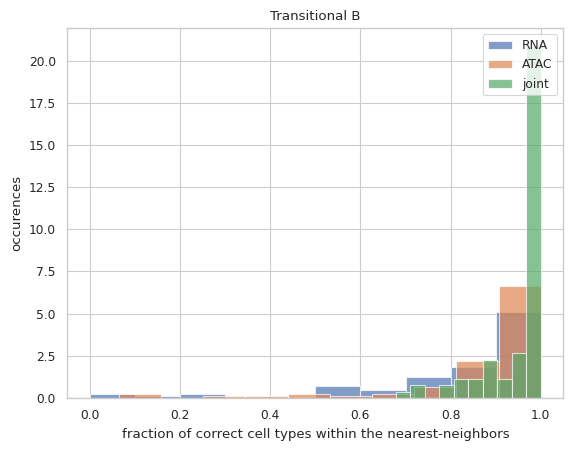

In [298]:
plt.hist(frac_RNA, bins=10, alpha=0.7, density=True)
plt.hist(frac_ATAC, bins=10, alpha=0.7, density=True)
plt.hist(frac_WNN, bins=10, alpha=0.7, density=True)
plt.legend({"RNA","ATAC","joint"}, loc=1)
#plt.ylim([0, 80])
plt.xlabel("fraction of correct cell types within the nearest-neighbors")
plt.ylabel("occurences")
plt.title("Transitional B")


In [301]:
frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="B1 B", cell_type_fraction="B1 B",
                                      neighbor_key="RNA_connectivities")

frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="B1 B", cell_type_fraction="B1 B",
                                      neighbor_key="ATAC_connectivities")

frac_WNN = compute_frac_celltypes_from_neighbors(adata, annotation_label= "manual_annotation_B_fine", 
                                      cell_type_query="B1 B", cell_type_fraction="B1 B",
                                      neighbor_key="WNN_connectivities")

Text(0.5, 1.0, 'B1 B')

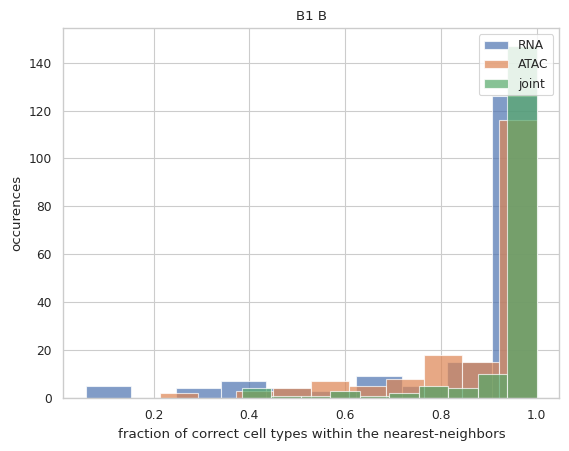

In [303]:
plt.hist(frac_RNA, bins=10, alpha=0.7)
plt.hist(frac_ATAC, bins=10, alpha=0.7)
plt.hist(frac_WNN, bins=10, alpha=0.7)
plt.legend({"RNA","ATAC","joint"}, loc=1)
# plt.ylim([0, 80])
plt.xlabel("fraction of correct cell types within the nearest-neighbors")
plt.ylabel("occurences")
plt.title("B1 B")


## conclusion

- 1) The fraction of correct cell-types within the nearest-neighbors is cleaner (higher) in "joint(RNA+ATAC)" than each individual modality (RNA or ATAC).

Now, let's generate a more comprehensive plots for this:

- bar plot showing each cell as a thin vertical line where the y-axis is the fraction of cell types in the nearest neighbors.
- Sort the bars from high to low (purer cells to less purer cells)



In [353]:
# function to compute the fraction of cell types for the neighbors within a group of cells
# output: a list of fractions for each cell (each cell from "cell_type_query" type)
def compute_frac_celltypes_from_neighbors(adata, annotation_label, 
                                          cell_type_interest, cell_types_fraction, neighbor_key):
    # input arguments:
    # adata: anndata object
    # annotation_label: adata.obs["annotation_label"], the level of annotation we will use
    # cell_type_query: cell type that we're curious about their nearest-neighbors
    # cell_type_fraction: cell type that we're curious about how much they take up within the "cell_type_query"'s nearest-neighbors
    # neighbor_key: the neighborhood key, which we need to specify which modality it was calculated from
    
    
    # subset the dataset for the given cell_type by getting indices
    cell_indices = np.where(adata.obs[annotation_label] == cell_type_interest)[0]
    
    # create an empty dataframe (cell_ids by cell_types)
    df_fractions = pd.DataFrame(index=adata.obs_names[cell_indices],
                                columns=cell_types_fraction)

    # loop through each cell and calculate the fraction of neighboring cells
    # that are of the same cell type
    neighborhood_fractions = np.zeros((len(cell_indices), len(cell_types)), dtype=np.float64)
    for idx in cell_indices:
        cell_id = adata.obs_names[idx]
        # get the indices of the neighbors of the current cell
        #neighbor_key = "connectivities"
        neighbor_indices = adata.obsp[neighbor_key][idx].nonzero()[1]
        # get the cell types of the neighbors
        neighbor_cell_types = adata.obs[annotation_label][neighbor_indices]
        # calculate the fraction of neighbors that are of the same cell type
        # 1 x num_cell_types numpy array (initialize)
        fractions=[] 
        for cell_type in cell_types_fraction:
            fraction = np.mean(neighbor_cell_types == cell_type)
            fractions.append(fraction)
            # neighborhood_fractions.append(fraction)
            
        df_fractions.loc[cell_id,:] = fractions
        
    return df_fractions

In [355]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
cell_type_interest = "B1 B"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ["B1 B", "Naive CD20+ B","Transitional B","unassigned"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ATAC_connectivities")
df_frac_joint = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="WNN_connectivities")

## transitional B cells

In [500]:
adata.uns["manual_annotation_B_fine_colors"] = adata.uns["cell_type_neurips_B_cells_colors"]

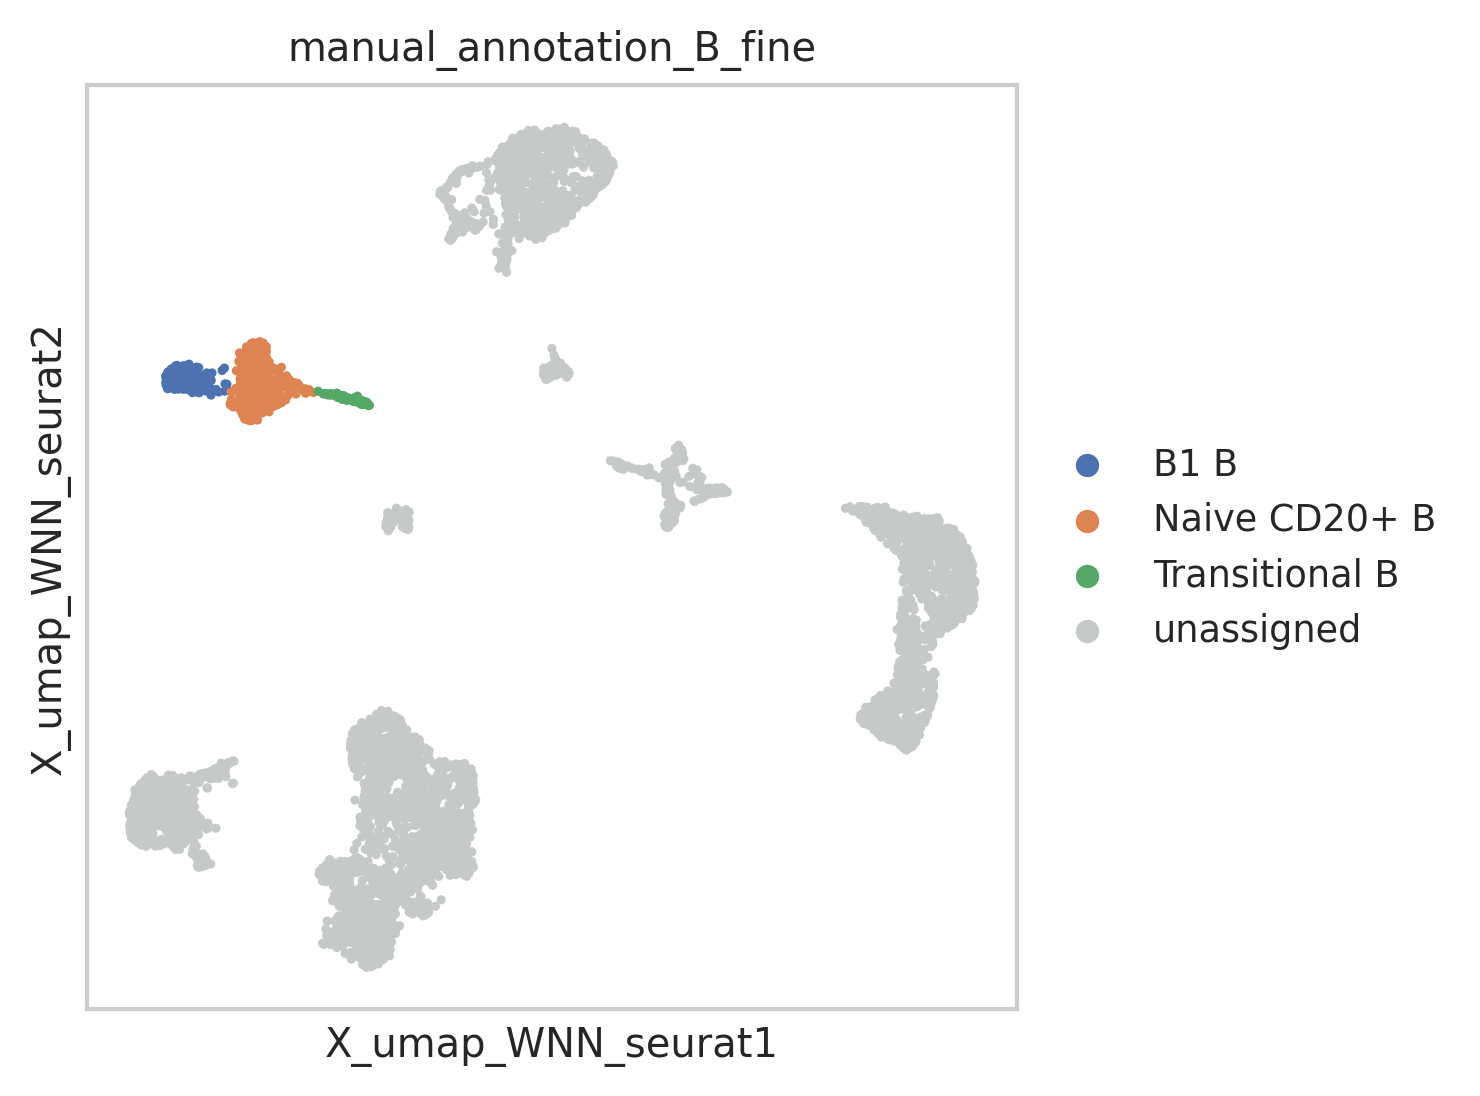

In [508]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata, basis = "X_umap_WNN_seurat", color="manual_annotation_B_fine",
                save="_manual_annotation_B_subtypes.pdf")

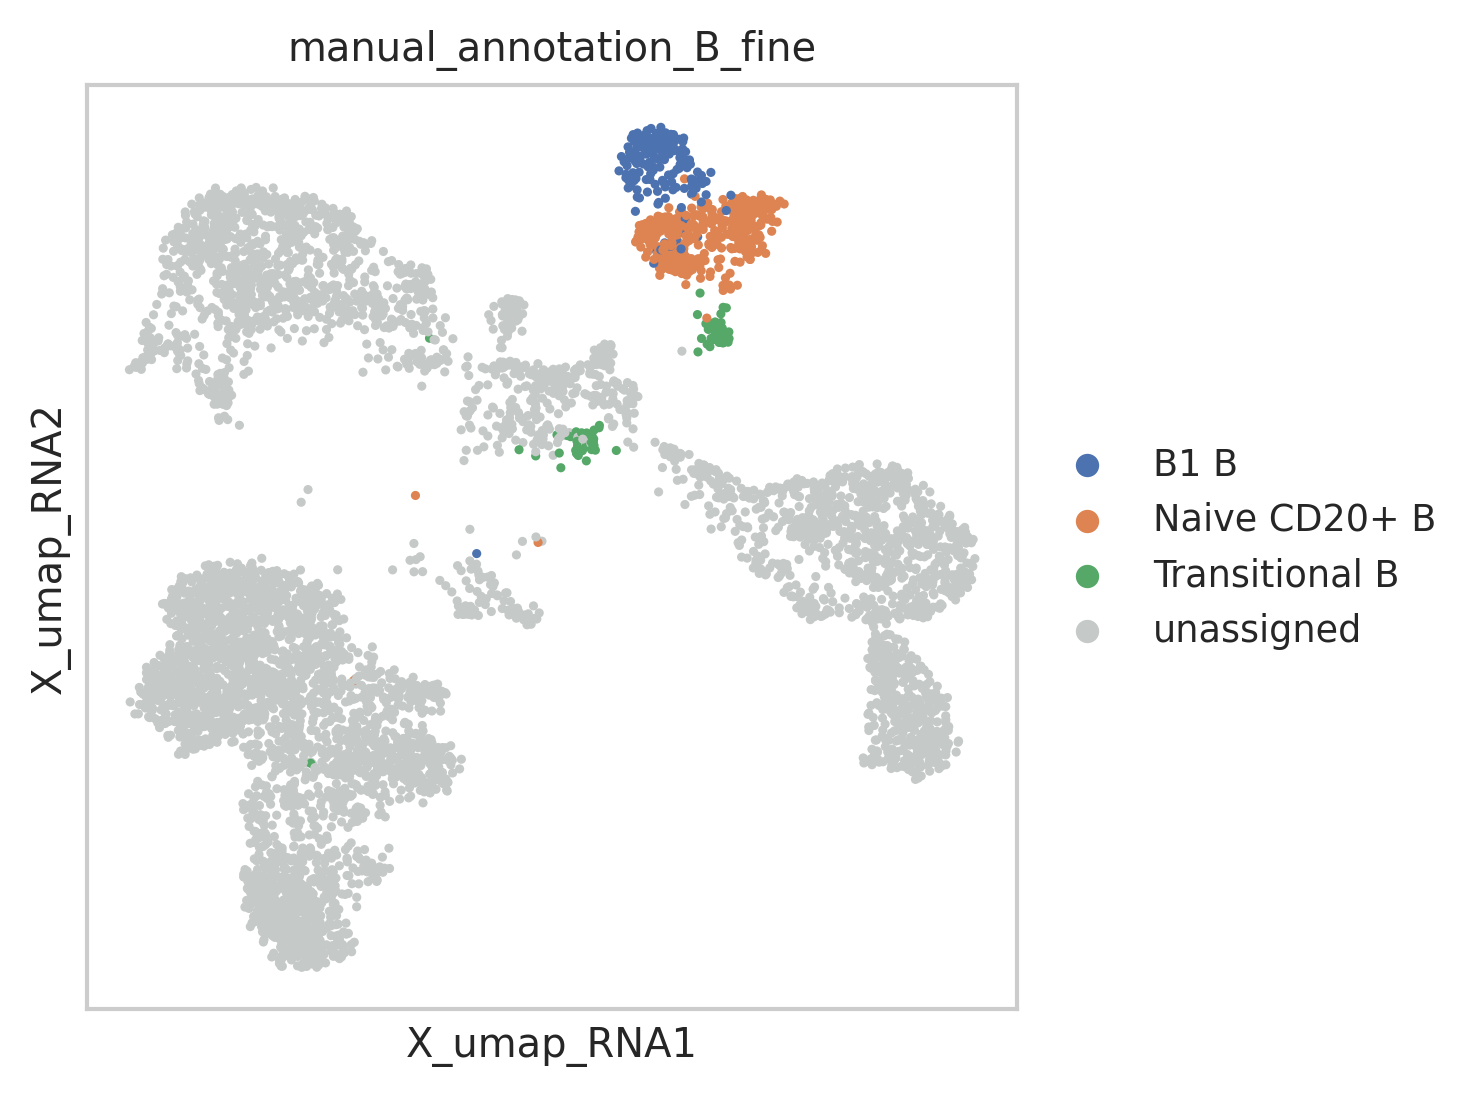

In [509]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata, basis = "X_umap_RNA", color="manual_annotation_B_fine",
                save="_manual_annotation_B_subtypes.pdf")

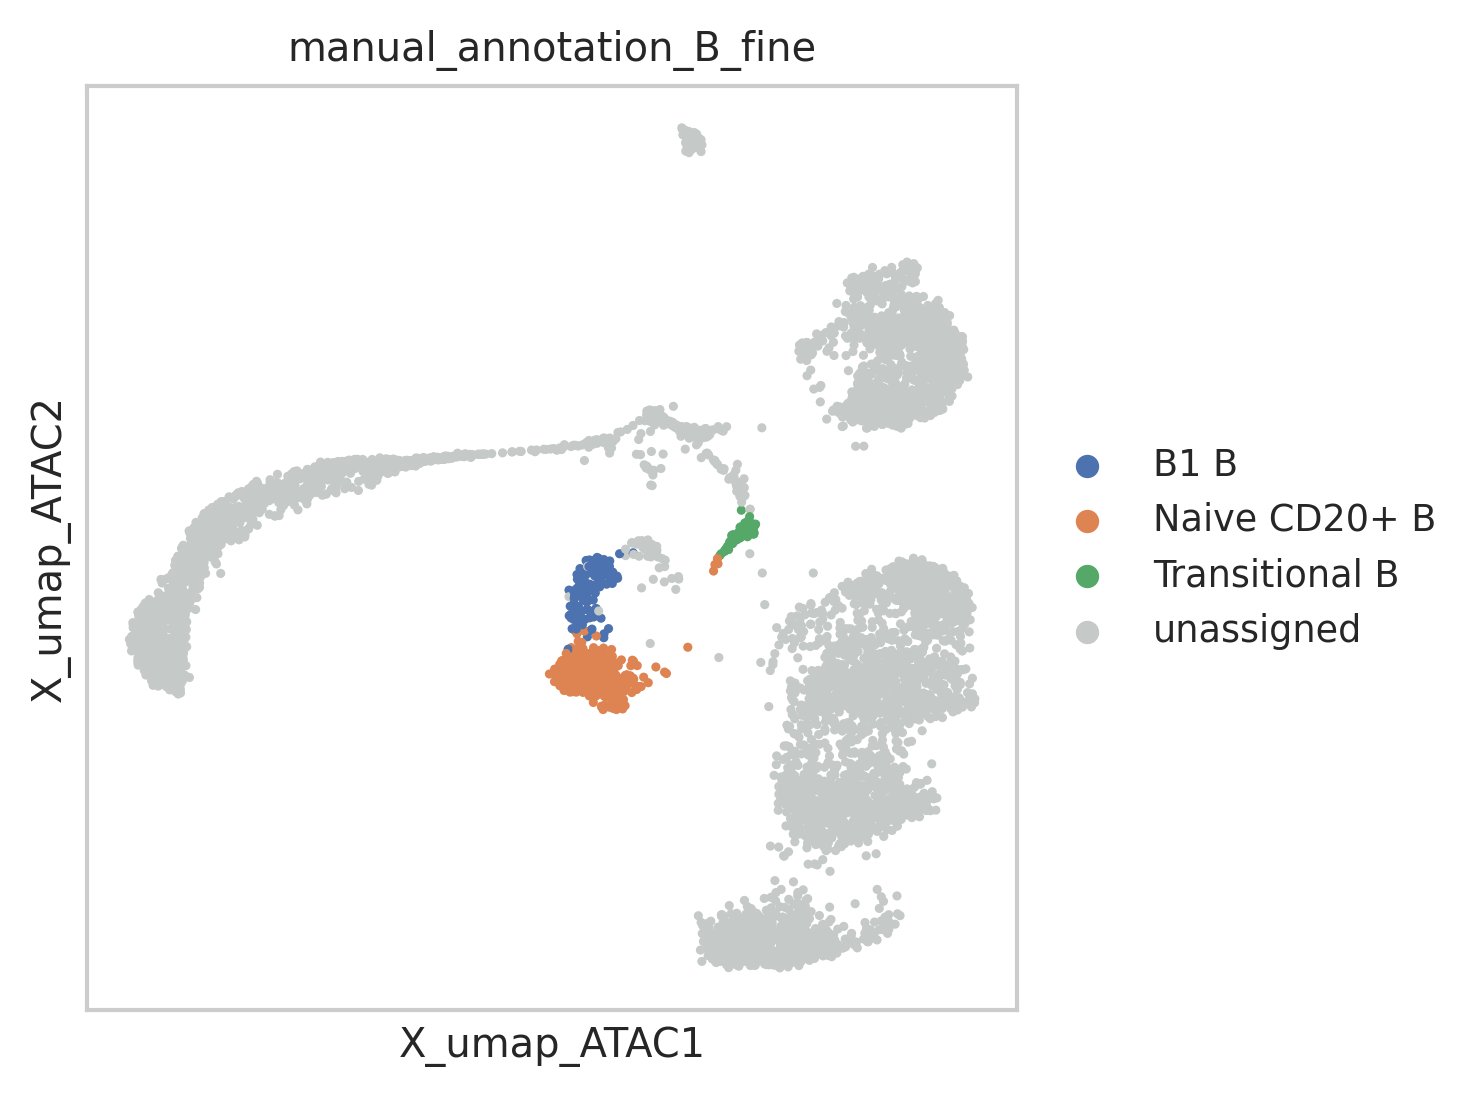

In [510]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata, basis = "X_umap_ATAC", color="manual_annotation_B_fine",
                save="_manual_annotation_B_subtypes.pdf")

In [547]:
adata.uns["manual_annotation_B_fine_colors"]

['#4c72b0', '#dd8452', '#55a868', '#C5C9C7']

In [548]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
cell_type_interest = "Transitional B"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ["B1 B", "Naive CD20+ B","Transitional B","unassigned"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ATAC_connectivities")
df_frac_joint = compute_frac_celltypes_from_neighbors(adata, annotation_label="manual_annotation_B_fine", 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="WNN_connectivities")

In [398]:
list_cols_order = ["Transitional B", "B1 B", "Naive CD20+ B", "unassigned"]
df_frac_RNA = df_frac_RNA.reindex(columns= list_cols_order)
df_frac_RNA

df_frac_ATAC = df_frac_ATAC.reindex(columns=list_cols_order)
df_frac_joint = df_frac_joint.reindex(columns=list_cols_order)

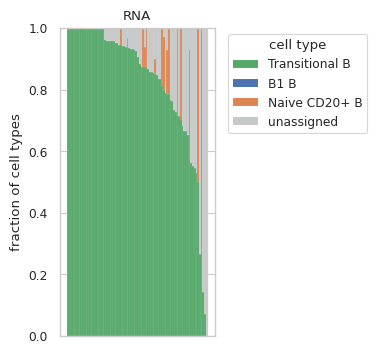

In [549]:
# ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7'] = ["B1 B","Naive CD20+ B", "Transitional B", "unassigned"]
df_sorted = df_frac_RNA.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
bar_width = 1
ax.bar(df_sorted.index,transB, color="#55a868", width=bar_width,label="Transitional B", linewidth=0.05)
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=bar_width, label="B1 B", linewidth=0.05)
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=bar_width, 
       label="Naive CD20+ B", linewidth=0.05)
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=bar_width, label="unassigned", linewidth=0.05)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("RNA")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

plt.savefig(figpath+"frac_manual_B_subtypes_neighbors_RNA_stacked_bars.pdf",
                dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

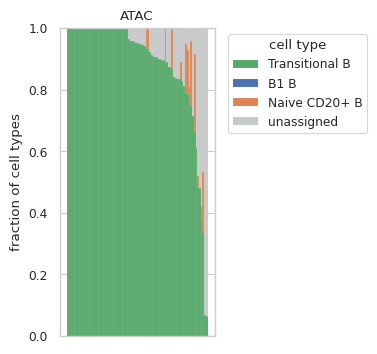

In [550]:
# ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7'] = ["B1 B", "Transitional B","Naive CD20+ B","unassigned"]
df_sorted = df_frac_ATAC.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
ax.bar(df_sorted.index,transB, color="#55a868", width=bar_width,label="Transitional B", linewidth=0.05)
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=bar_width, label="B1 B", linewidth=0.05)
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=bar_width, 
       label="Naive CD20+ B", linewidth=0.05)
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=bar_width, label="unassigned", linewidth=0.05)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("ATAC")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_manual_B_subtypes_neighbors_ATAC_stacked_bars.pdf",
           dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

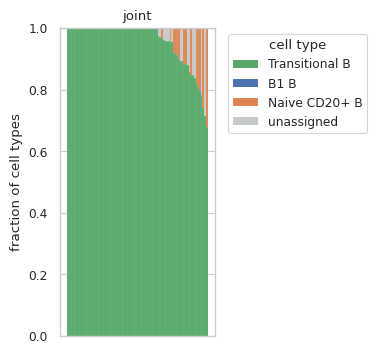

In [551]:
# ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7'] = ["B1 B", "Transitional B","Naive CD20+ B","unassigned"]
df_sorted = df_frac_joint.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
ax.bar(df_sorted.index,transB, color="#55a868", width=bar_width,label="Transitional B", linewidth=0.05)
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=bar_width, label="B1 B", linewidth=0.05)
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=bar_width, 
       label="Naive CD20+ B", linewidth=0.05)
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=bar_width, label="unassigned", linewidth=0.05)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("joint")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_manual_B_subtypes_neighbors_joint_stacked_bars.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

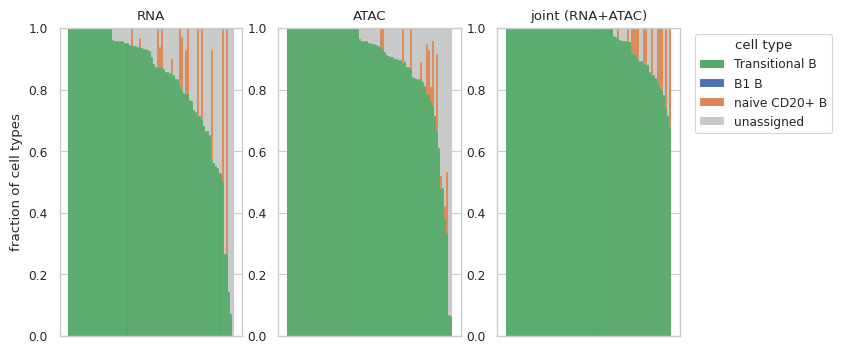

In [553]:
# Combined figure
fig, axs = plt.subplots(1,3, figsize=(8,4))

# RNA
df_sorted = df_frac_RNA.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

axs[0].bar(df_sorted.index,transB, color="#55a868", width=bar_width,label="Transitional B", linewidth=0.05)
axs[0].bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=bar_width, label="B1 B", linewidth=0.05)
axs[0].bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=bar_width, 
       label="Naive CD20+ B", linewidth=0.05)
axs[0].bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=bar_width, label="unassigned", linewidth=0.05)
#ax = df_sorted.plot(kind="bar", stacked=True, width=1)
axs[0].set_ylabel("fraction of cell types")
axs[0].set_xticklabels([])
axs[0].set_title("RNA")

# ATAC
df_sorted = df_frac_ATAC.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

axs[1].bar(df_sorted.index,transB, color="#55a868", width=1,label="Transitional B", linewidth = 0.05)
axs[1].bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B", linewidth = 0.05)
axs[1].bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=1, 
       label="naive CD20+ B", linewidth = 0.05)
axs[1].bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned", linewidth = 0.05)
#ax = df_sorted.plot(kind="bar", stacked=True, width=1)
#axs[1].set_ylabel("fraction of cell types")
axs[1].set_xticklabels([])
axs[1].set_title("ATAC")


# joint
df_sorted = df_frac_joint.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"Naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

axs[2].bar(df_sorted.index,transB, color="#55a868", width=1,label="Transitional B", linewidth = 0.05)
axs[2].bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B", linewidth = 0.05)
axs[2].bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=1, 
       label="naive CD20+ B", linewidth = 0.05)
axs[2].bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned", linewidth = 0.05)
#ax = df_sorted.plot(kind="bar", stacked=True, width=1)
#axs[1].set_ylabel("fraction of cell types")
axs[2].set_xticklabels([])
axs[2].set_title("joint (RNA+ATAC)")
axs[2].legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

plt.savefig(figpath+"frac_B_subtypes_manual_annotation_neighbors_stacked_bars_combined.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

## Using the neurips 2021 annotation (as the ground truth)



In [404]:
adata.obs.cell_type.unique().to_list()

['CD4+ T naive',
 'Lymph prog',
 'CD4+ T activated',
 'Erythroblast',
 'CD8+ T',
 'naive CD20+ B',
 'CD14+ Mono',
 'HSC',
 'NK',
 'pDC',
 'B1 B',
 'G/M prog',
 'Normoblast',
 'CD16+ Mono',
 'MK/E prog',
 'ILC',
 'ID2-hi myeloid prog',
 'Proerythroblast',
 'cDC2',
 'Transitional B',
 'Plasma cells']

In [405]:
cell_type_dict = {'CD4+ T naive': 'unassigned',
                  'Lymph prog': 'unassigned',
                  'CD4+ T activated': 'unassigned',
                  'Erythroblast': 'unassigned',
                  'CD8+ T': 'unassigned',
                  'naive CD20+ B': 'naive CD20+ B',
                  'CD14+ Mono': 'unassigned',
                  'HSC': 'unassigned',
                  'NK': 'unassigned',
                  'pDC': 'unassigned',
                  'B1 B': 'B1 B',
                  'G/M prog': 'unassigned',
                  'Normoblast': 'unassigned',
                  'CD16+ Mono': 'unassigned',
                  'MK/E prog': 'unassigned',
                  'ILC': 'unassigned',
                  'ID2-hi myeloid prog': 'unassigned',
                  'Proerythroblast': 'unassigned',
                  'cDC2': 'unassigned',
                  'Transitional B': 'Transitional B',
                  'Plasma cells': 'unassigned'}

In [408]:
# generate an annotation label where only the B cell subtypes were labelled

adata.obs["cell_type_neurips_B_cells"] = adata.obs["cell_type"].map(cell_type_dict)
adata.obs["cell_type_neurips_B_cells"]

AAACAGCCAATTAAGG-1    unassigned
AAACAGCCAGGCTGTT-1    unassigned
AAACATGCAAAGCGCA-1    unassigned
AAACATGCAATAACCT-1    unassigned
AAACATGCAATAATGG-1    unassigned
                         ...    
TTTGTGTTCATGTGGT-1    unassigned
TTTGTGTTCATTTGCT-1    unassigned
TTTGTGTTCGCCTAAG-1    unassigned
TTTGTTGGTACGGTAC-1    unassigned
TTTGTTGGTTCGGTAA-1    unassigned
Name: cell_type_neurips_B_cells, Length: 6224, dtype: object

In [463]:
adata.obs.cell_type_neurips_B_cells.unique()

['unassigned', 'naive CD20+ B', 'B1 B', 'Transitional B']
Categories (4, object): ['B1 B', 'Transitional B', 'naive CD20+ B', 'unassigned']

In [411]:
adata.obsm["X_umap_WNN_seurat"] = adata_test.obsm["X_umap_WNN_seurat"]

In [419]:
adata.uns["cell_type_neurips_B_cells_colors"] = ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7']

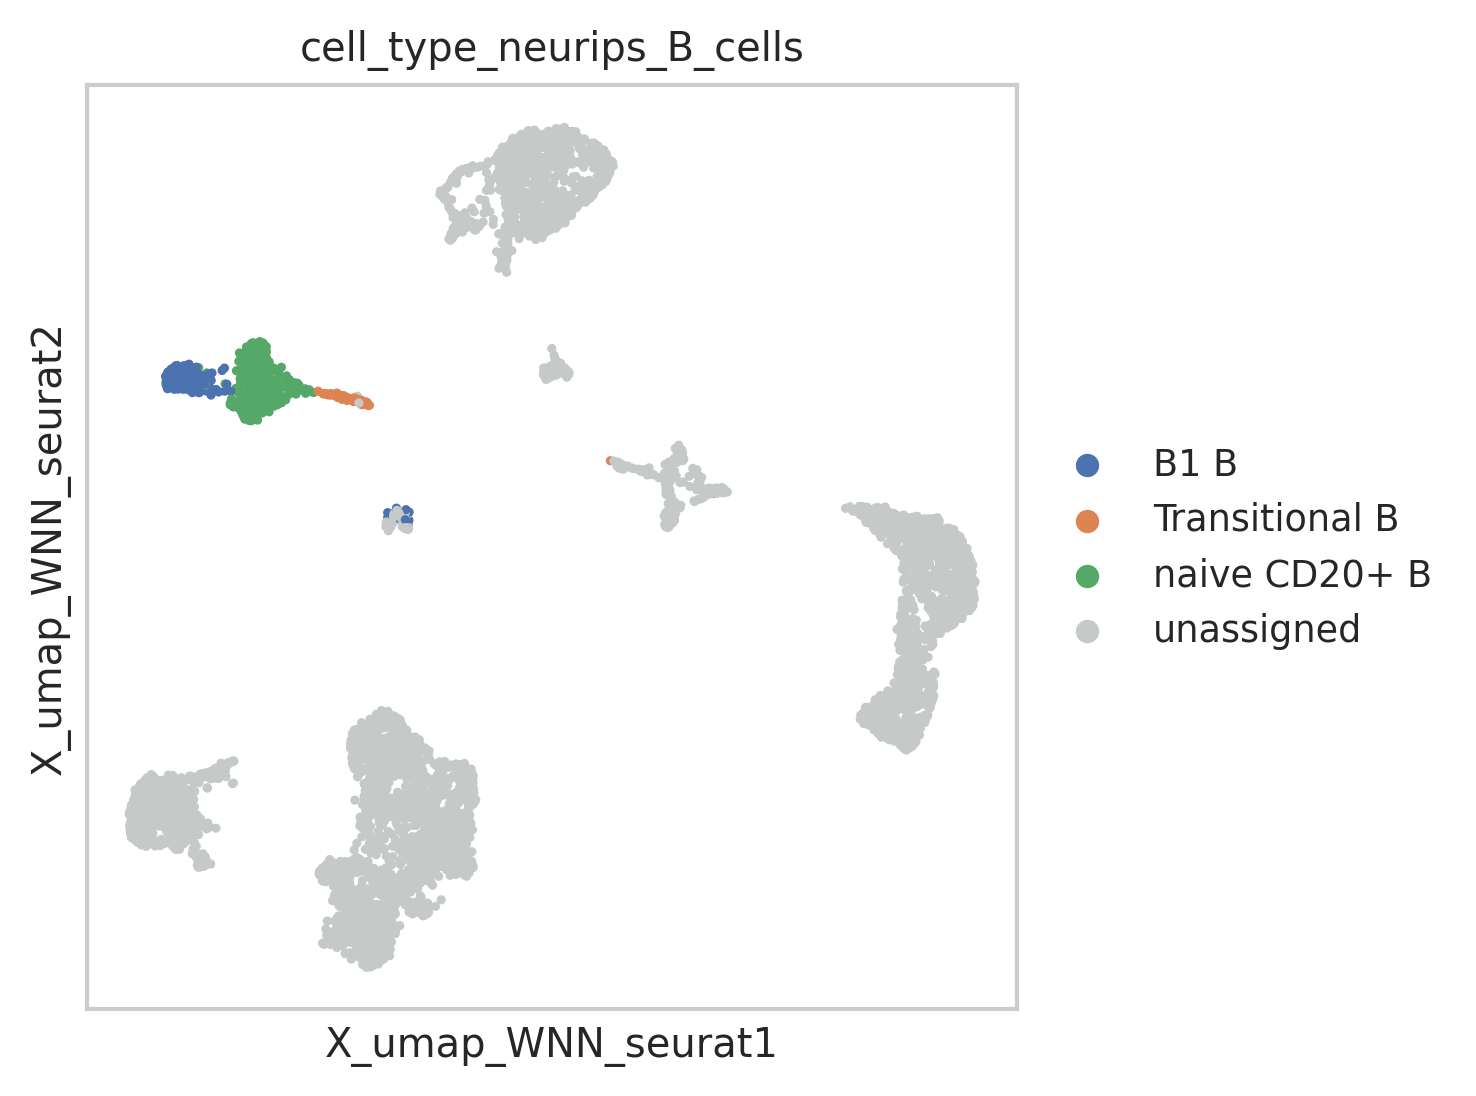

In [528]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata,basis="X_umap_WNN_seurat",color="cell_type_neurips_B_cells", 
                save="_neurips_annotation_Bcells.pdf")

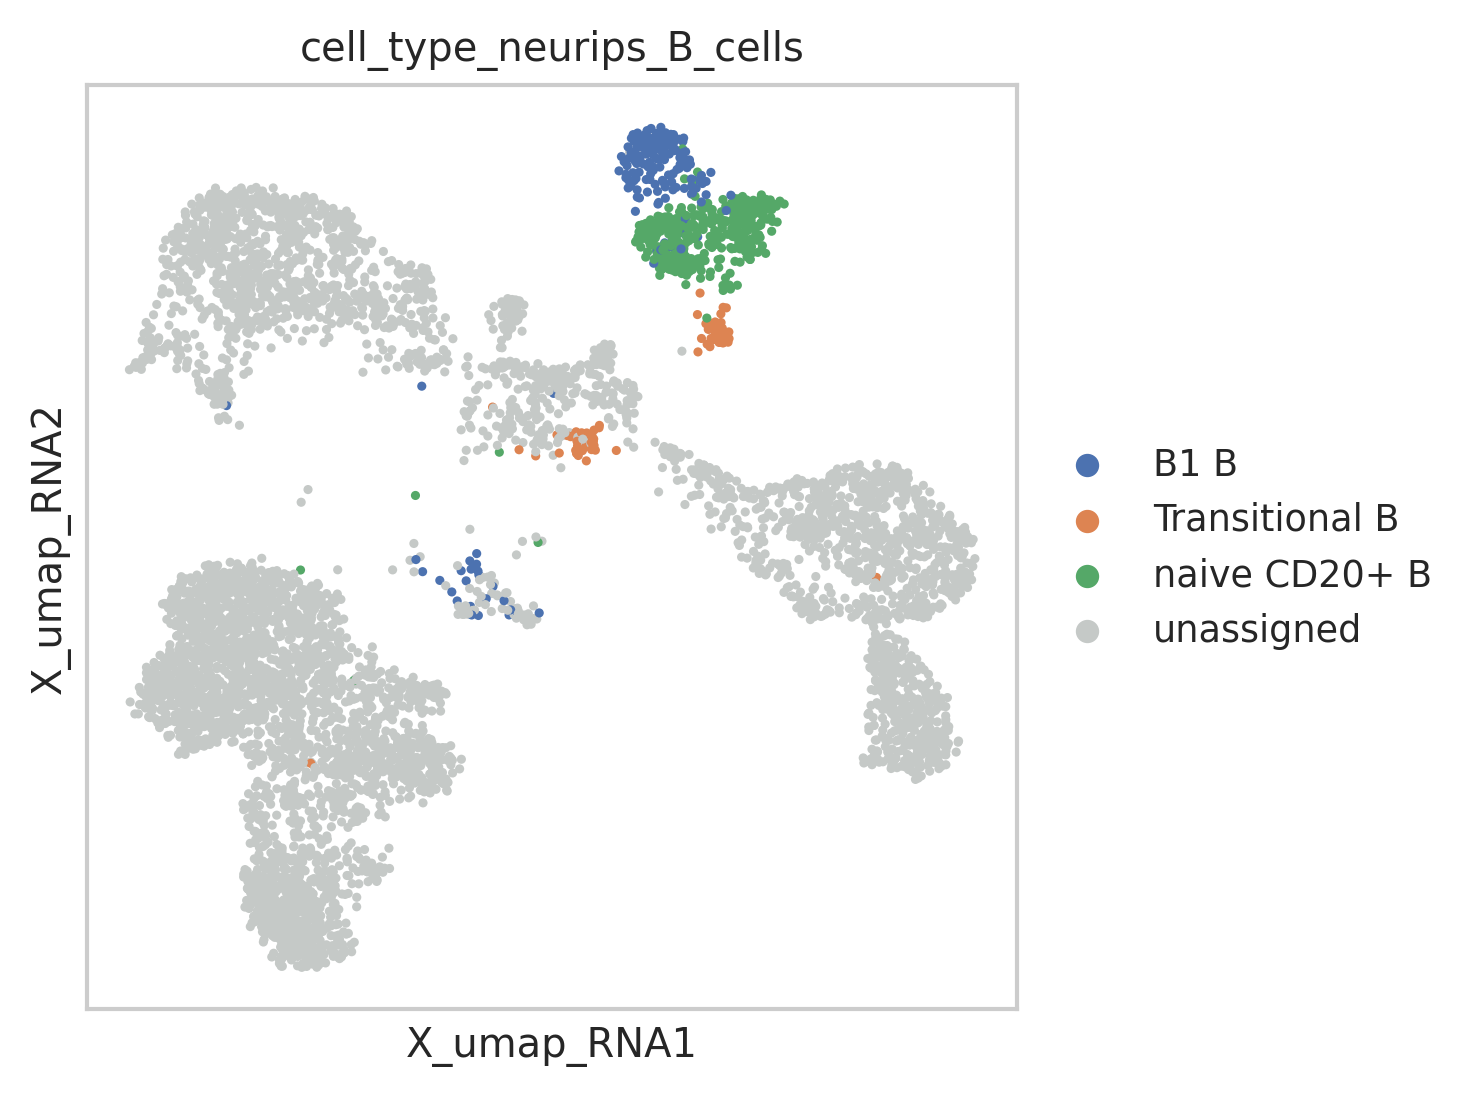

In [529]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata,basis="X_umap_RNA",color="cell_type_neurips_B_cells", 
                save="_neurips_annotation_Bcells.pdf")

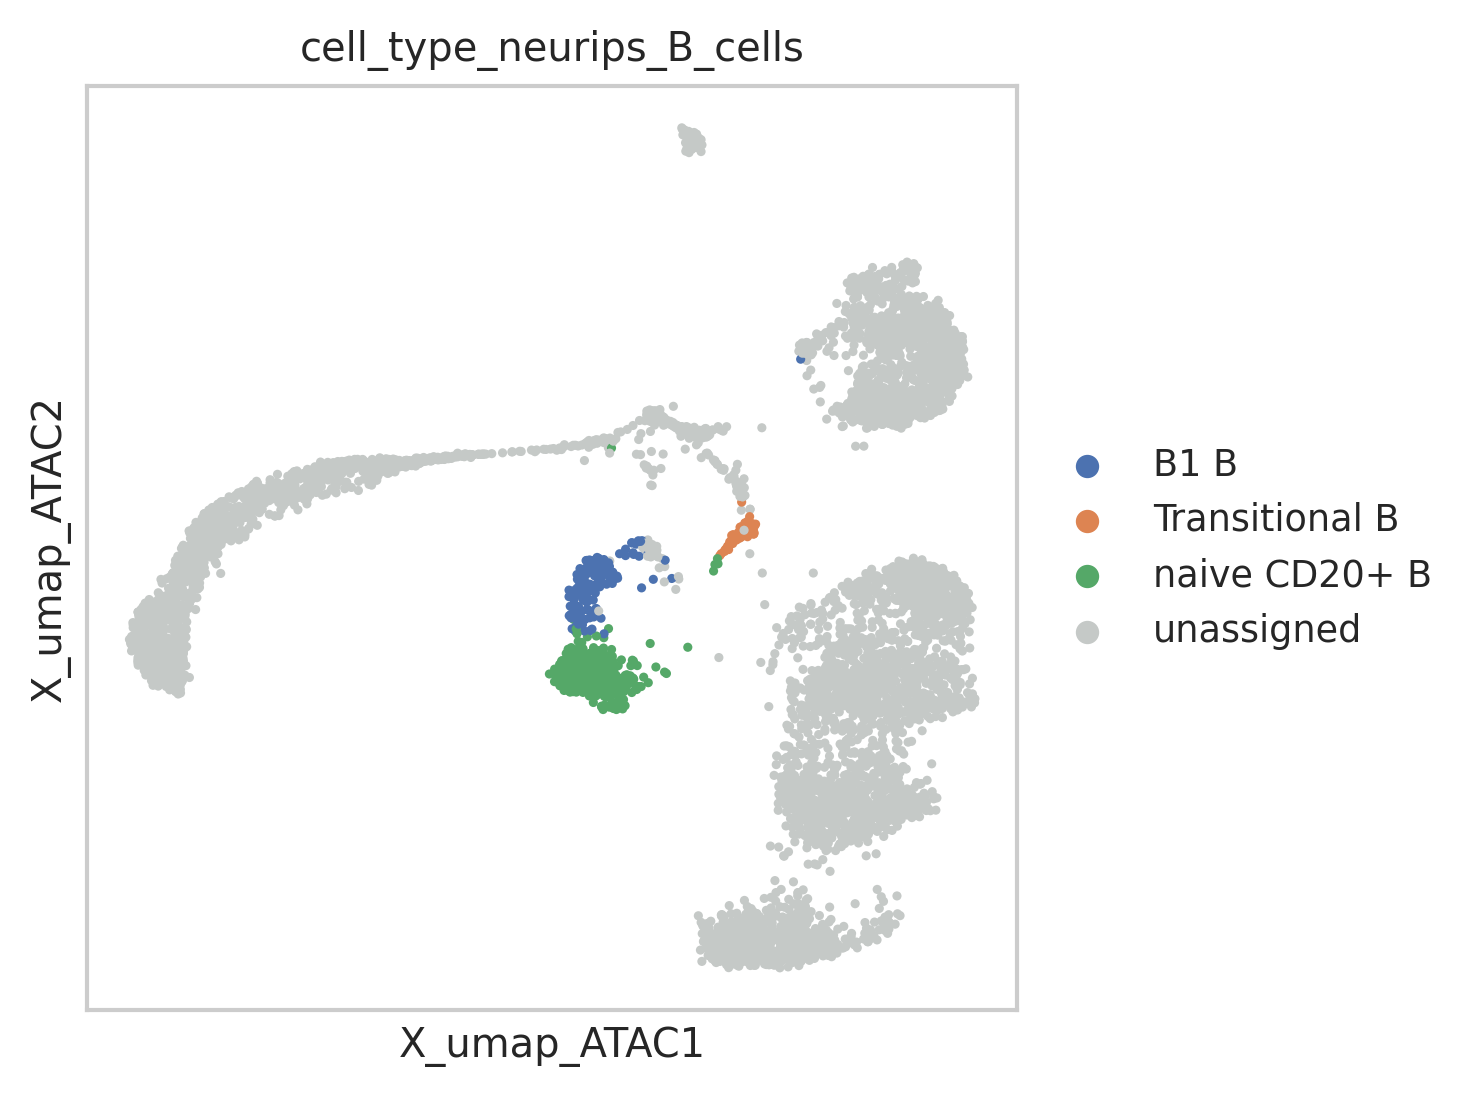

In [530]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (300)}):
    sc.pl.embedding(adata,basis="X_umap_ATAC",color="cell_type_neurips_B_cells", 
                save="_neurips_annotation_Bcells.pdf")

In [555]:
# Target cell type (the cell type that we're interested in knowing how "pure" its neighbors are)
cell_type_interest = "Transitional B"
# annotation label
annotation_class = "cell_type_neurips_B_cells"

# all cell types (adata.obs["manual_annotation_B_fine"].unique().to_list())
cell_types = ["Transitional B", "B1 B", "naive CD20+ B","unassigned"]

df_frac_RNA = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="RNA_connectivities")
df_frac_ATAC = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="ATAC_connectivities")
df_frac_joint = compute_frac_celltypes_from_neighbors(adata, annotation_label=annotation_class, 
                                            cell_type_interest=cell_type_interest, 
                                            cell_types_fraction=cell_types, 
                                            neighbor_key="WNN_connectivities")

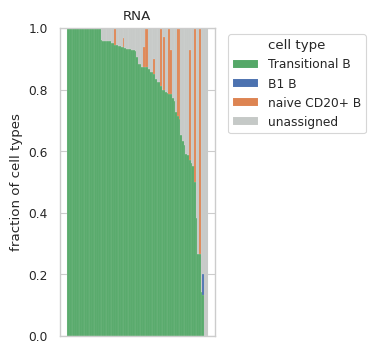

In [556]:
# ['#4c72b0', '#dd8452', '#55a868', '#C5C9C7'] = ["B1 B", "Transitional B","Naive CD20+ B","unassigned"]
df_sorted = df_frac_RNA.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
ax.bar(df_sorted.index,transB, color="#55a868", width=1,label="Transitional B", linewidth=0.05)
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B", linewidth=0.05)
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=1, 
       label="naive CD20+ B", linewidth=0.05)
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned", linewidth=0.05)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("RNA")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_B_subtypes_neighbors_RNA_stacked_bars.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

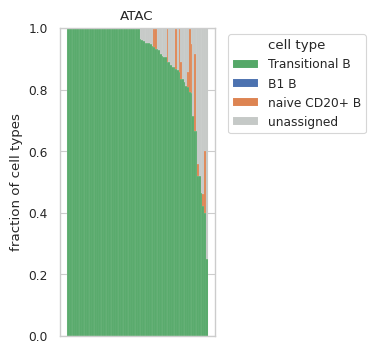

In [557]:
df_sorted = df_frac_ATAC.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
ax.bar(df_sorted.index,transB, color="#55a868", width=1,label="Transitional B", linewidth = 0.05)
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B", linewidth = 0.05)
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=1, 
       label="naive CD20+ B", linewidth = 0.05)
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned", linewidth = 0.05)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("ATAC")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_B_subtypes_neighbors_ATAC_stacked_bars.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

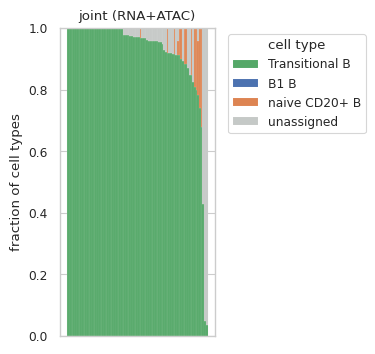

In [558]:
df_sorted = df_frac_joint.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

fig, ax = plt.subplots(figsize=(2,4))
ax.bar(df_sorted.index,transB, color="#55a868", width=1,label="Transitional B", linewidth = 0.05)
ax.bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B", linewidth = 0.05)
ax.bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=1, 
       label="naive CD20+ B", linewidth = 0.05)
ax.bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned", linewidth = 0.05)
#ax = df_sorted.plot(kind="bar", stacked=True, width=1)
ax.set_ylabel("fraction of cell types")
ax.set_xticklabels([])
ax.set_title("joint (RNA+ATAC)")
ax.legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.savefig(figpath+"frac_B_subtypes_neighbors_joint_stacked_bars.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

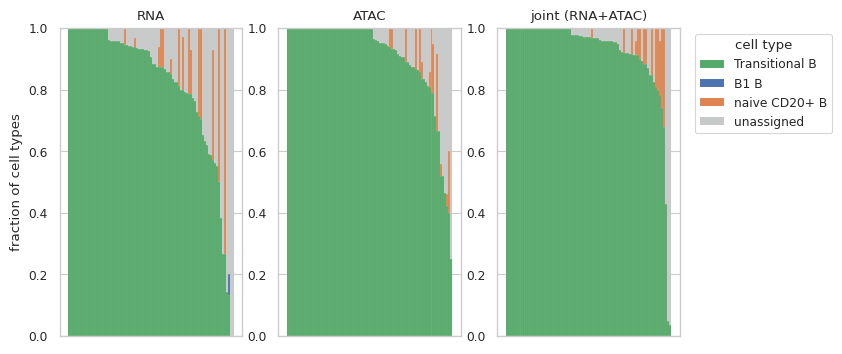

In [559]:
fig, axs = plt.subplots(1,3, figsize=(8,4))

# RNA
df_sorted = df_frac_RNA.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

axs[0].bar(df_sorted.index,transB, color="#55a868", width=1,label="Transitional B", linewidth = 0.05)
axs[0].bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B", linewidth = 0.05)
axs[0].bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=1, 
       label="naive CD20+ B", linewidth = 0.05)
axs[0].bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned", linewidth = 0.05)
#ax = df_sorted.plot(kind="bar", stacked=True, width=1)
axs[0].set_ylabel("fraction of cell types")
axs[0].set_xticklabels([])
axs[0].set_title("RNA")

# ATAC
df_sorted = df_frac_ATAC.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

axs[1].bar(df_sorted.index,transB, color="#55a868", width=1,label="Transitional B", linewidth = 0.05)
axs[1].bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B", linewidth = 0.05)
axs[1].bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=1, 
       label="naive CD20+ B", linewidth = 0.05)
axs[1].bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned", linewidth = 0.05)
#ax = df_sorted.plot(kind="bar", stacked=True, width=1)
#axs[1].set_ylabel("fraction of cell types")
axs[1].set_xticklabels([])
axs[1].set_title("ATAC")


# joint
df_sorted = df_frac_joint.sort_values('Transitional B', ascending=False)
transB = df_sorted.loc[:,"Transitional B"].to_list()
B1B = df_sorted.loc[:,"B1 B"].to_list()
naiveCD20B = df_sorted.loc[:,"naive CD20+ B"].to_list()
unassigned = df_sorted.loc[:,"unassigned"].to_list()

axs[2].bar(df_sorted.index,transB, color="#55a868", width=1,label="Transitional B", linewidth = 0.05)
axs[2].bar(df_sorted.index, B1B, bottom=transB, color="#4c72b0", width=1, label="B1 B", linewidth = 0.05)
axs[2].bar(df_sorted.index, naiveCD20B, bottom= [sum(x) for x in zip(transB, B1B)], color="#dd8452", width=1, 
       label="naive CD20+ B", linewidth = 0.05)
axs[2].bar(df_sorted.index, unassigned,bottom = [sum(x) for x in zip(transB, B1B, naiveCD20B)], 
       color="#C5C9C7", width=1, label="unassigned", linewidth = 0.05)
#ax = df_sorted.plot(kind="bar", stacked=True, width=1)
#axs[1].set_ylabel("fraction of cell types")
axs[2].set_xticklabels([])
axs[2].set_title("joint (RNA+ATAC)")
axs[2].legend(title="cell type", bbox_to_anchor=(1.05,1), loc="upper left")

plt.savefig(figpath+"frac_neurips_B_subtypes_neighbors_stacked_bars_combined.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

In [587]:
adata.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_multiome/s1d1_rna_atac_joint_v7.h5ad")